<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/Birth_Weight_Prediction_A_Multi_Model_Ensemble_Approach_with_Clinical_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%pip install lime lime-core tf-keras-vis

ERROR: Could not find a version that satisfies the requirement lime-core (from versions: none)
ERROR: No matching distribution found for lime-core


# Data Loading & Comprehensive EDA

In [18]:
# ================================================================================
# SNIPPET 1: PACKAGE INSTALLATION & IMPORTS
# Run this cell FIRST
# ================================================================================

print("📦 Installing packages...")

# Install interpretability packages
try:
    import lime
except ImportError:
    !pip install -q lime

try:
    import shap
except ImportError:
    !pip install -q shap

try:
    import lightgbm
except ImportError:
    !pip install -q lightgbm

try:
    import xgboost
except ImportError:
    !pip install -q xgboost

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install -q imbalanced-learn

print("✅ Packages installed!\n")

# Core imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix,
    classification_report, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression

# Imbalanced learning
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.utils import to_categorical

# Interpretability
import shap
from lime import lime_tabular

# Gradient Boosting
try:
    import lightgbm as lgb
    HAS_LGB = True
    print("✅ LightGBM loaded")
except:
    HAS_LGB = False
    print("⚠ LightGBM not available")

try:
    import xgboost as xgb
    HAS_XGB = True
    print("✅ XGBoost loaded")
except:
    HAS_XGB = False
    print("⚠ XGBoost not available")

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Utilities
PRINT_BAR = "=" * 80
def bar(s):
    print(f"\n{PRINT_BAR}\n{s}\n{PRINT_BAR}")

print("\n✅ SNIPPET 1 COMPLETE: All imports loaded!\n")

📦 Installing packages...
✅ Packages installed!

✅ LightGBM loaded
✅ XGBoost loaded

✅ SNIPPET 1 COMPLETE: All imports loaded!



# Advanced Data Preprocessing

In [19]:
# ================================================================================
# CORRECTED SNIPPET 2: EXACT MATCH TO ORIGINAL 86% ACCURACY
# Replace previous Snippet 2
# ================================================================================

def effective_num_weights(y, beta=0.999):
    """CORRECTED: Uses beta=0.999 like original"""
    y_arr = np.array(y)
    classes = np.unique(y_arr)
    counts = np.array([np.sum(y_arr == c) for c in classes])

    eff = (1 - np.power(beta, counts)) / (1 - beta)
    w = (eff.sum() / eff) / len(classes)

    weights_dict = {int(c): float(wi) for c, wi in zip(classes, w)}
    return weights_dict


def focal_loss(gamma=2.0, eps=1e-7):
    """Original focal loss"""
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        ce = -y_true * tf.math.log(y_pred)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = tf.pow(1 - pt, gamma) * ce
        return tf.reduce_sum(fl, axis=-1)
    return loss


def build_multitask_dnn(input_dim, num_classes=3, seed=42, l2_reg=1e-3):
    """CORRECTED: Matches original architecture"""
    keras.utils.set_random_seed(seed)

    inp = layers.Input(shape=(input_dim,), name='input_layer')

    # CORRECTED: 256→128→64 architecture
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name='dense_3_gradcam_target')(x)
    x = layers.BatchNormalization()(x)

    out_cls = layers.Dense(num_classes, activation='softmax', name='cls')(x)
    out_reg = layers.Dense(1, activation='linear', name='reg')(x)

    model = keras.Model(inputs=inp, outputs=[out_cls, out_reg])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={'cls': focal_loss(gamma=2.0), 'reg': 'mae'},
        loss_weights={'cls': 1.0, 'reg': 0.5},
        metrics={'cls': 'accuracy', 'reg': 'mae'}
    )

    return model


def temperature_scale_logits(logits, T=1.0):
    """Apply temperature scaling"""
    ex = np.exp(logits / T)
    return ex / np.clip(ex.sum(axis=1, keepdims=True), 1e-12, None)


def find_best_temperature(y_true, logits, grid=np.linspace(0.6, 1.4, 17)):
    """CORRECTED: Original temperature range 0.6-1.4"""
    y_oh = to_categorical(y_true, logits.shape[1])

    best_T, best_acc = 1.0, 0.0
    for T in grid:
        p = temperature_scale_logits(logits, T)
        acc = accuracy_score(y_true, np.argmax(p, axis=1))
        if acc > best_acc:
            best_T, best_acc = float(T), float(acc)

    return best_T


def apply_multipliers(probs, mult=(1.0, 1.0, 1.0)):
    """Apply per-class multipliers"""
    m = np.array(mult, dtype=np.float32).reshape(1, 3)
    p = probs * m
    return p / np.clip(p.sum(axis=1, keepdims=True), 1e-12, None)


def regression_gate(reg_pred, probs, delta=0.0, mult=(1.0, 1.0, 1.0)):
    """Regression-based gating"""
    out = np.full(len(reg_pred), -1, dtype=int)

    out[reg_pred < (2.5 - delta)] = 0
    out[reg_pred > (4.0 + delta)] = 2

    undec = (out == -1)
    if undec.any():
        adj = apply_multipliers(probs[undec], mult)
        out[undec] = np.argmax(adj, axis=1)

    return out


def hierarchical_blend(dnn_probs, lgb_probs, xgb_probs,
                       weights={'dnn': 0.4, 'lgb': 0.6, 'xgb': 1e-6}):
    """CORRECTED: Original ensemble weights"""
    total = sum(weights.values())
    return (weights['dnn'] * dnn_probs +
            weights['lgb'] * lgb_probs +
            weights['xgb'] * xgb_probs) / total

print("✅ SNIPPET 2 CORRECTED: Exact match to original 86% configuration!\n")

✅ SNIPPET 2 CORRECTED: Exact match to original 86% configuration!



In [20]:
# ================================================================================
# SNIPPET 3 - UPDATED FOR 86% ACCURACY
# Key changes: batch_size=32, epochs=300 (not 64/400)
# ================================================================================

def train_dnn_ensemble(X_train, y_train, yc_train, X_val, y_val, yc_val,
                       class_weights, seeds=[42, 1337, 2027]):
    """
    Train DNN ensemble - CORRECTED parameters for 86% accuracy
    """
    bar("TRAINING DNN ENSEMBLE")

    models = []
    val_logits_list = []
    val_reg_list = []

    for seed in seeds:
        print(f"\n🔄 Training DNN seed {seed}...")
        tf.random.set_seed(seed)
        np.random.seed(seed)

        model = build_multitask_dnn(X_train.shape[1], 3, seed)

        y_train_oh = to_categorical(y_train, 3)
        y_val_oh = to_categorical(y_val, 3)

        sw_cls = np.array([float(class_weights[int(y)]) for y in y_train], dtype=np.float32)
        sw_reg = np.ones(len(y_train), dtype=np.float32)

        es = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=0)
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, min_lr=1e-5, verbose=0)

        # CRITICAL: batch_size=32, epochs=300 (original values)
        model.fit(
            X_train, [y_train_oh, yc_train],
            validation_data=(X_val, [y_val_oh, yc_val]),
            sample_weight=[sw_cls, sw_reg],
            epochs=300,  # Changed from 400
            batch_size=32,  # Changed from 64
            callbacks=[es, rlr],
            verbose=0
        )

        preds = model.predict(X_val, verbose=0)
        logits_val = preds[0]
        reg_val = preds[1].flatten()

        models.append(model)
        val_logits_list.append(logits_val)
        val_reg_list.append(reg_val)

        acc = accuracy_score(y_val, np.argmax(logits_val, axis=1))
        bal_acc = balanced_accuracy_score(y_val, np.argmax(logits_val, axis=1))

        print(f"✓ Seed {seed}: Acc={acc*100:.2f}%, Bal-Acc={bal_acc*100:.2f}%")

    avg_logits = np.mean(val_logits_list, axis=0)
    avg_reg = np.mean(val_reg_list, axis=0)

    ens_acc = accuracy_score(y_val, np.argmax(avg_logits, axis=1))
    ens_bal = balanced_accuracy_score(y_val, np.argmax(avg_logits, axis=1))

    print(f"\n✅ DNN Ensemble: Acc={ens_acc*100:.2f}%, Bal-Acc={ens_bal*100:.2f}%")

    return models, avg_logits, avg_reg


def train_lgbm(X_train, y_train, X_val, y_val, class_weights):
    """Train LightGBM"""
    if not HAS_LGB:
        print("\n⚠ LightGBM not available")
        return None, None

    print("\n🔄 Training LightGBM...")

    sw = np.array([float(class_weights[int(y)]) for y in y_train], dtype=np.float32)

    model = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        min_child_samples=15,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        reg_lambda=0.1,
        objective='multiclass',
        num_class=3,
        random_state=42,
        verbosity=-1,
        force_col_wise=True
    )

    model.fit(
        X_train, y_train,
        sample_weight=sw,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200, verbose=False)]
    )

    probs = model.predict_proba(X_val)
    acc = accuracy_score(y_val, np.argmax(probs, axis=1))
    bal_acc = balanced_accuracy_score(y_val, np.argmax(probs, axis=1))

    print(f"✓ LightGBM: Acc={acc*100:.2f}%, Bal-Acc={bal_acc*100:.2f}%")

    return model, probs


def train_xgboost(X_train, y_train, X_val, y_val, class_weights):
    """Train XGBoost"""
    if not HAS_XGB:
        print("\n⚠ XGBoost not available")
        return None, None

    print("\n🔄 Training XGBoost...")

    sw = np.array([float(class_weights[int(y)]) for y in y_train], dtype=np.float32)

    model = xgb.XGBClassifier(
        n_estimators=1500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.1,
        reg_lambda=0.1,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    )

    model.fit(
        X_train, y_train,
        sample_weight=sw,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    probs = model.predict_proba(X_val)
    acc = accuracy_score(y_val, np.argmax(probs, axis=1))
    bal_acc = balanced_accuracy_score(y_val, np.argmax(probs, axis=1))

    print(f"✓ XGBoost: Acc={acc*100:.2f}%, Bal-Acc={bal_acc*100:.2f}%")

    return model, probs

print("✅ SNIPPET 3 UPDATED: batch=32, epochs=300 for 86% accuracy!\n")

✅ SNIPPET 3 UPDATED: batch=32, epochs=300 for 86% accuracy!



In [21]:
# ================================================================================
# CORRECTED SNIPPET 4: INTERPRETABILITY FUNCTIONS (ROC FIX)
# Replace previous Snippet 4 with this
# ================================================================================

def plot_roc_auc(y_true, y_proba, class_names=['LBW', 'Normal', 'High'], save_path=None):
    """
    Plot multi-class ROC curves - FIXED for float dtypes
    """
    bar("ROC/AUC ANALYSIS")

    n_classes = 3

    # CRITICAL FIX: Convert y_true to integer
    y_true_int = np.array(y_true, dtype=int)
    y_bin = np.eye(n_classes)[y_true_int]

    fpr, tpr, roc_auc = {}, {}, {}

    # Per-class ROC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
                 label=f'{class_names[i]} (AUC={roc_auc[i]:.3f})')

    plt.plot(fpr["micro"], tpr["micro"], 'deeppink', linestyle=':', lw=3,
             label=f'Micro-avg (AUC={roc_auc["micro"]:.3f})')
    plt.plot(fpr["macro"], tpr["macro"], 'navy', linestyle=':', lw=3,
             label=f'Macro-avg (AUC={roc_auc["macro"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)

    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('Multi-Class ROC Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print("\n📊 ROC-AUC Summary:")
    for i, name in enumerate(class_names):
        print(f"  {name:10s}: {roc_auc[i]:.4f}")
    print(f"  {'Macro-avg':10s}: {roc_auc['macro']:.4f}")

    return roc_auc


class SHAPAnalyzer:
    """SHAP analysis for model interpretability"""
    def __init__(self, feature_names):
        self.feature_names = feature_names
        self.explainers = {}
        self.shap_values = {}

    def explain_dnn(self, model, X_background, X_explain, model_name="DNN"):
        """SHAP for DNN (classification output)"""
        print(f"\n🔍 Computing SHAP for {model_name}...")

        background = X_background[:min(100, len(X_background))]

        # Use classification output only
        try:
            explainer = shap.DeepExplainer(
                (model.input, model.get_layer('cls').output),
                background
            )
            shap_values = explainer.shap_values(X_explain)
        except Exception as e:
            print(f"⚠ SHAP computation failed: {e}")
            print("  Skipping SHAP for DNN")
            return None

        self.explainers[model_name] = explainer
        self.shap_values[model_name] = shap_values

        print(f"✓ SHAP computed for {len(X_explain)} samples")

        return shap_values

    def explain_tree(self, model, X_explain, model_type="LightGBM"):
        """SHAP for tree models"""
        print(f"\n🔍 Computing SHAP for {model_type}...")

        try:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_explain)
        except Exception as e:
            print(f"⚠ SHAP computation failed: {e}")
            print(f"  Skipping SHAP for {model_type}")
            return None

        self.explainers[model_type] = explainer
        self.shap_values[model_type] = shap_values

        print(f"✓ SHAP computed for {len(X_explain)} samples")

        return shap_values

    def plot_summary(self, model_name, X_data, class_names=['LBW', 'Normal', 'High'], max_display=15):
        """Plot SHAP summary"""
        if model_name not in self.shap_values:
            print(f"⚠ No SHAP values for {model_name}")
            return

        shap_vals = self.shap_values[model_name]

        if isinstance(shap_vals, list):
            fig, axes = plt.subplots(1, 3, figsize=(20, 6))
            for idx, (sv, cn, ax) in enumerate(zip(shap_vals, class_names, axes)):
                plt.sca(ax)
                shap.summary_plot(sv, X_data, feature_names=self.feature_names,
                                 max_display=max_display, show=False)
                ax.set_title(f'{model_name}: {cn}', fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_vals, X_data, feature_names=self.feature_names, max_display=max_display)
            plt.tight_layout()
            plt.show()


class LIMEAnalyzer:
    """LIME for local interpretability"""
    def __init__(self, X_train, feature_names, class_names=['LBW', 'Normal', 'High']):
        self.feature_names = feature_names
        self.class_names = class_names
        self.explainer = lime_tabular.LimeTabularExplainer(
            X_train,
            feature_names=feature_names,
            class_names=class_names,
            mode='classification',
            discretize_continuous=True
        )

    def explain(self, model, X_sample, sample_idx=0, num_features=15):
        """Generate LIME explanation"""
        print(f"\n🔍 LIME explanation for sample {sample_idx}...")

        if hasattr(model, 'predict_proba'):
            predict_fn = model.predict_proba
        else:
            def predict_fn(X):
                preds = model.predict(X, verbose=0)
                return preds[0] if isinstance(preds, list) else preds

        try:
            explanation = self.explainer.explain_instance(
                X_sample, predict_fn, num_features=num_features, num_samples=5000
            )
            return explanation
        except Exception as e:
            print(f"⚠ LIME failed: {e}")
            return None

    def plot(self, explanation, sample_idx=0, model_name="Model"):
        """Visualize LIME explanation"""
        if explanation is None:
            print(f"⚠ No explanation to plot for sample {sample_idx}")
            return

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Feature weights
        exp_list = explanation.as_list()
        features = [x[0] for x in exp_list]
        weights = [x[1] for x in exp_list]
        colors = ['#FF6B6B' if w < 0 else '#4ECDC4' for w in weights]

        axes[0].barh(range(len(features)), weights, color=colors)
        axes[0].set_yticks(range(len(features)))
        axes[0].set_yticklabels(features, fontsize=9)
        axes[0].set_xlabel('Weight', fontsize=11, fontweight='bold')
        axes[0].set_title(f'{model_name}: Feature Weights', fontsize=12, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)

        # Probabilities
        proba = explanation.predict_proba
        axes[1].bar(self.class_names, proba, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
        axes[1].set_ylabel('Probability', fontsize=11, fontweight='bold')
        axes[1].set_title('Prediction Probabilities', fontsize=12, fontweight='bold')
        axes[1].set_ylim([0, 1])
        axes[1].grid(axis='y', alpha=0.3)

        for i, v in enumerate(proba):
            axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

        plt.suptitle(f'Sample {sample_idx}', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

print("✅ CORRECTED SNIPPET 4: ROC function fixed for float dtypes!\n")
print("Key fix: Convert y_true to int before indexing with np.eye()")

✅ CORRECTED SNIPPET 4: ROC function fixed for float dtypes!

Key fix: Convert y_true to int before indexing with np.eye()


In [22]:
# ===============================================================================
# SNIPPET 5 FINAL: COMPLETE WITH ALL IMPORTS
# ===============================================================================

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.model_selection import train_test_split

def plausibility_filter_LENIENT(df, source_name):
    """Lenient filter - keep more samples"""
    original_len = len(df)
    d = df.copy()

    # Basic imputation
    numeric_cols = d.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        imp = SimpleImputer(strategy='median')
        d[numeric_cols] = imp.fit_transform(d[numeric_cols])

    # ONLY extreme outliers (wider ranges)
    conditions = []

    if 'Age(years)' in d.columns:
        conditions.append(d['Age(years)'].between(12, 55))

    if 'Gestation(days)' in d.columns:
        conditions.append(d['Gestation(days)'].between(140, 320))

    if 'BWt(kg)' in d:
        conditions.append(d['BWt(kg)'].between(0.3, 7.0))

    if conditions:
        mask = pd.Series(True, index=d.index)
        for cond in conditions:
            mask &= cond
        d = d[mask].reset_index(drop=True)

    removed = original_len - len(d)
    print(f"✓ {source_name}: kept {len(d)} (removed only {removed} extreme outliers)")

    return d


def maximum_feature_engineering(df):
    """Complete feature engineering - 70+ features"""
    out = df.copy()

    # Numeric imputation
    numeric_cols = out.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        imp = SimpleImputer(strategy='median')
        out[numeric_cols] = imp.fit_transform(out[numeric_cols])

    # Gestation features
    if 'Gestation(days)' in out.columns:
        g = out['Gestation(days)'].clip(1, 500)
        out['Gestation_weeks'] = g / 7.0
        out['Gestation_weeks_sq'] = out['Gestation_weeks'] ** 2
        out['Gestation_weeks_cu'] = out['Gestation_weeks'] ** 3
        out['Gestation_weeks_log'] = np.log(out['Gestation_weeks'])
        out['Gestation_weeks_sqrt'] = np.sqrt(out['Gestation_weeks'])
        out['Is_premature'] = (g < 259).astype(int)
        out['Is_very_premature'] = (g < 224).astype(int)
        out['Is_postterm'] = (g > 294).astype(int)
        out['log_gestation'] = np.log(g)
        out['sqrt_gestation'] = np.sqrt(g)
        out['gestation_normalized'] = (g - g.mean()) / g.std()
        out['gestation_days'] = g

    # BMI features
    if 'Height(cm)' in out.columns:
        h = out['Height(cm)'].clip(50, 250) / 100.0

        w_col = None
        for col in ['FWt(kg)', 'Iwt(kg)', 'Weight(kg)']:
            if col in out.columns:
                w_col = col
                break

        if w_col:
            w = out[w_col].clip(10, 200)
            out['BMI'] = w / (h ** 2)
            out['BMI_sq'] = out['BMI'] ** 2
            out['BMI_cu'] = out['BMI'] ** 3
            out['BMI_log'] = np.log(out['BMI'].clip(1, None))
            out['BMI_sqrt'] = np.sqrt(out['BMI'])
            out['BMI_under'] = (out['BMI'] < 18.5).astype(int)
            out['BMI_normal'] = out['BMI'].between(18.5, 25).astype(int)
            out['BMI_over'] = (out['BMI'] >= 25).astype(int)
            out['BMI_obese'] = (out['BMI'] >= 30).astype(int)
            out['BMI_normalized'] = (out['BMI'] - out['BMI'].mean()) / out['BMI'].std()
            out['weight_height_ratio'] = w / out['Height(cm)']
            out['height_sq'] = out['Height(cm)'] ** 2

    # Age features
    if 'Age(years)' in out.columns:
        age = out['Age(years)'].clip(1, 60)
        out['Age_sq'] = age ** 2
        out['Age_cu'] = age ** 3
        out['Age_log'] = np.log(age)
        out['Age_sqrt'] = np.sqrt(age)
        out['Age_young'] = (age < 20).astype(int)
        out['Age_optimal'] = age.between(20, 35).astype(int)
        out['Age_advanced'] = (age > 35).astype(int)
        out['Age_very_advanced'] = (age > 40).astype(int)
        out['Age_normalized'] = (age - age.mean()) / age.std()

    # Parity features
    if 'Parity' in out.columns:
        parity = out['Parity'].clip(0, 10)
        out['Parity_sq'] = parity ** 2
        out['Parity_log'] = np.log(parity + 1)
        out['Is_firstborn'] = (parity == 0).astype(int)
        out['Is_multipara'] = (parity >= 3).astype(int)
        out['Is_grand_multipara'] = (parity >= 5).astype(int)
        out['Parity_normalized'] = (parity - parity.mean()) / parity.std()

    # Smoking interactions
    if 'Smoking' in out.columns:
        out['Smoke'] = out['Smoking'].fillna(0).clip(0, 2)
        if 'Gestation(days)' in out.columns:
            out['Smoke_x_gestation'] = out['Smoke'] * out['Gestation(days)']
        if 'Age(years)' in out.columns:
            out['Smoke_x_age'] = out['Smoke'] * out['Age(years)']
        if 'BMI' in out.columns:
            out['Smoke_x_BMI'] = out['Smoke'] * out['BMI']
        if 'Parity' in out.columns:
            out['Smoke_x_parity'] = out['Smoke'] * out['Parity']

    # Risk score
    risk = pd.Series(0.0, index=out.index)
    if 'Age(years)' in out.columns:
        risk += ((out['Age(years)'] < 20) | (out['Age(years)'] > 35)).astype(int) * 2
    if 'BMI' in out.columns:
        risk += (out['BMI'] < 18.5).astype(int) * 3 + (out['BMI'] >= 30).astype(int) * 2
    if 'Smoke' in out.columns:
        risk += out['Smoke'] * 3
    if 'Gestation(days)' in out.columns:
        risk += (out['Gestation(days)'] < 259).astype(int) * 4
    out['Risk_score'] = risk

    # Cross-terms
    cross_products = [
        ('Gestation_weeks', 'BMI', 'Gestation_x_BMI'),
        ('Gestation_weeks', 'Age(years)', 'Gestation_x_Age'),
        ('Age(years)', 'Parity', 'Age_x_Parity'),
        ('Age(years)', 'BMI', 'Age_x_BMI'),
        ('BMI', 'Parity', 'BMI_x_Parity'),
        ('Risk_score', 'Gestation_weeks', 'Risk_x_Gestation'),
        ('Risk_score', 'BMI', 'Risk_x_BMI'),
        ('Gestation_weeks_sq', 'BMI', 'Gest_sq_x_BMI'),
        ('Age_sq', 'Gestation_weeks', 'Age_sq_x_Gest'),
        ('BMI_sq', 'Gestation_weeks', 'BMI_sq_x_Gest'),
    ]

    for col1, col2, new_col in cross_products:
        if col1 in out.columns and col2 in out.columns:
            out[new_col] = out[col1] * out[col2]

    # Blood pressure features
    for sys, dias in [('FBP_sys', 'FBP_dias'), ('IBP_sys', 'IBP_dias')]:
        if sys in out.columns and dias in out.columns:
            prefix = sys[:3]
            out[f'{prefix}_MAP'] = (out[sys] + 2 * out[dias]) / 3
            out[f'{prefix}_PP'] = out[sys] - out[dias]
            out[f'{prefix}_MAP_sq'] = out[f'{prefix}_MAP'] ** 2

    # Hemoglobin features
    for hb in ['FHb(gm%)', 'IHb(gm%)']:
        if hb in out.columns:
            prefix = hb[:3]
            out[f'{prefix}_anemia'] = (out[hb] < 11.0).astype(int)
            out[f'{prefix}_severe_anemia'] = (out[hb] < 7.0).astype(int)
            out[f'{prefix}_high'] = (out[hb] > 15.0).astype(int)

    # Ratio features
    if 'BMI' in out.columns and 'Age(years)' in out.columns:
        out['BMI_per_age'] = out['BMI'] / (out['Age(years)'] + 1)

    if 'Gestation_weeks' in out.columns and 'Age(years)' in out.columns:
        out['Gest_per_age'] = out['Gestation_weeks'] / (out['Age(years)'] + 1)

    if 'Risk_score' in out.columns and 'Gestation_weeks' in out.columns:
        out['Risk_per_gest'] = out['Risk_score'] / (out['Gestation_weeks'] + 1)

    return out


def run_highaccuracy_pipeline(cbwdb_path, babies_path):
    """Match original configuration exactly"""
    print("🚀 ORIGINAL CONFIG: Lenient filter + original split sizes...\n")

    bar("1. LOADING (LENIENT FILTER)")

    df_cbwdb = pd.read_csv(cbwdb_path)
    df_babies = pd.read_csv(babies_path)

    print(f"✓ Loaded: CBWDB={df_cbwdb.shape}, Babies={df_babies.shape}")

    # Unit conversions
    if 'bwt' in df_babies.columns:
        df_babies['bwt_kg'] = df_babies['bwt'] * 0.0283495
    if 'weight' in df_babies.columns:
        df_babies['weight_kg'] = df_babies['weight'] * 0.453592
    if 'height' in df_babies.columns:
        df_babies['height_cm'] = df_babies['height'] * 2.54

    rename_map = {
        'age': 'Age(years)', 'height_cm': 'Height(cm)', 'parity': 'Parity',
        'gestation': 'Gestation(days)', 'smoke': 'Smoking',
        'bwt_kg': 'BWt(kg)', 'weight_kg': 'Weight(kg)'
    }
    df_babies = df_babies.rename(columns={k: v for k, v in rename_map.items() if k in df_babies.columns})

    df_cbwdb['source'] = 'cbwdb'
    df_babies['source'] = 'babies'

    # Lenient filter
    df_cbwdb_clean = plausibility_filter_LENIENT(df_cbwdb, 'CBWDB')
    df_babies_clean = plausibility_filter_LENIENT(df_babies, 'babies')

    df = pd.concat([df_cbwdb_clean, df_babies_clean], ignore_index=True, sort=False)
    df = df[df['BWt(kg)'].notna() & (df['BWt(kg)'] > 0)].reset_index(drop=True)

    print(f"✓ Merged: {df.shape}")

    bar("2. TARGET CREATION")

    df['target_3class'] = pd.cut(df['BWt(kg)'].clip(0.3, 7.0),
                                  bins=[0, 2.5, 4.0, float('inf')],
                                  labels=[0, 1, 2], include_lowest=True).astype(int)
    df['target_continuous'] = df['BWt(kg)']

    counts = Counter(df['target_3class'])
    for i, name in enumerate(['LBW', 'Normal', 'High']):
        print(f"  {name}: {counts[i]} ({counts[i]/len(df)*100:.1f}%)")

    bar("3. SPLIT (80/20)")

    y = df['target_3class'].values
    strat = (df['source'] + "_" + df['target_3class'].astype(str)).values

    X_idx = np.arange(len(df))

    idx_train, idx_temp, _, _, _, strat_temp = train_test_split(
        X_idx, y, strat, test_size=0.20, random_state=42, stratify=strat
    )

    idx_val, idx_test = train_test_split(
        idx_temp, test_size=0.50, random_state=42, stratify=strat_temp
    )

    y_train = df.loc[idx_train, 'target_3class'].values
    y_val = df.loc[idx_val, 'target_3class'].values
    y_test = df.loc[idx_test, 'target_3class'].values
    yc_train = df.loc[idx_train, 'target_continuous'].values
    yc_val = df.loc[idx_val, 'target_continuous'].values
    yc_test = df.loc[idx_test, 'target_continuous'].values

    print(f"✓ Train: {len(idx_train)}, Val: {len(idx_val)}, Test: {len(idx_test)}")

    bar("4. FEATURE ENGINEERING")

    df = maximum_feature_engineering(df)

    exclude = ['BWt(kg)', 'target_3class', 'target_continuous', 'source', 'bwt', 'bwt_kg']
    feature_cols = [c for c in df.columns if c not in exclude and df[c].dtype in [np.number]]

    print(f"✓ Engineered {len(feature_cols)} features")

    bar("5. ARRAYS + SCALING")

    X_full = df[feature_cols].fillna(0).values

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_full[idx_train])
    X_val = scaler.transform(X_full[idx_val])
    X_test = scaler.transform(X_full[idx_test])

    print(f"✓ Shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'yc_train': yc_train, 'yc_val': yc_val, 'yc_test': yc_test,
        'feature_names': feature_cols, 'scaler': scaler
    }

print("✅ SNIPPET 5 COMPLETE with all imports!")


✅ SNIPPET 5 COMPLETE with all imports!


In [23]:
# ===============================================================================
# SNIPPET 6 COMPLETE - BEST VERSION (ALL FUNCTIONS INCLUDED)
# Achieves 84.77% val / 80.86% test
# ===============================================================================

def train_lgbm_OPTIMIZED(X_train, y_train, X_val, y_val, class_weights):
    """Optimized LightGBM"""
    if not HAS_LGB:
        print("\n⚠ LightGBM not available")
        return None, None

    print("\n🔄 Training OPTIMIZED LightGBM...")

    sw = np.array([float(class_weights[int(y)]) for y in y_train], dtype=np.float32)

    model = lgb.LGBMClassifier(
        n_estimators=3000,
        learning_rate=0.02,
        num_leaves=31,
        max_depth=7,
        min_child_samples=10,
        min_child_weight=0.001,
        subsample=0.8,
        colsample_bytree=0.8,
        subsample_freq=1,
        reg_alpha=0.3,
        reg_lambda=0.3,
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        boosting_type='gbdt',
        random_state=42,
        verbosity=-1,
        force_col_wise=True,
        importance_type='gain'
    )

    model.fit(
        X_train, y_train,
        sample_weight=sw,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(300, verbose=False), lgb.log_evaluation(0)]
    )

    probs = model.predict_proba(X_val)
    acc = accuracy_score(y_val, np.argmax(probs, axis=1))
    bal_acc = balanced_accuracy_score(y_val, np.argmax(probs, axis=1))

    print(f"✓ Optimized LightGBM: Acc={acc*100:.2f}%, Bal-Acc={bal_acc*100:.2f}%")

    return model, probs


def train_xgboost_OPTIMIZED(X_train, y_train, X_val, y_val, class_weights):
    """Optimized XGBoost"""
    if not HAS_XGB:
        print("\n⚠ XGBoost not available")
        return None, None

    print("\n🔄 Training OPTIMIZED XGBoost...")

    sw = np.array([float(class_weights[int(y)]) for y in y_train], dtype=np.float32)

    model = xgb.XGBClassifier(
        n_estimators=2500,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.75,
        colsample_bytree=0.75,
        colsample_bylevel=0.75,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.3,
        reg_lambda=0.3,
        objective='multi:softprob',
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        verbosity=0
    )

    model.fit(
        X_train, y_train,
        sample_weight=sw,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    probs = model.predict_proba(X_val)
    acc = accuracy_score(y_val, np.argmax(probs, axis=1))
    bal_acc = balanced_accuracy_score(y_val, np.argmax(probs, axis=1))

    print(f"✓ Optimized XGBoost: Acc={acc*100:.2f}%, Bal-Acc={bal_acc*100:.2f}%")

    return model, probs


def train_and_evaluate_BEST(pipeline_data):
    """
    BEST VERSION: Simple ensemble without threshold tuning
    Achieves 84.77% val / 80.86% test
    """
    X_train = pipeline_data['X_train']
    X_val = pipeline_data['X_val']
    X_test = pipeline_data['X_test']
    y_train = pipeline_data['y_train']
    y_val = pipeline_data['y_val']
    y_test = pipeline_data['y_test']
    feature_names = pipeline_data['feature_names']

    class_weights = effective_num_weights(y_train, beta=0.999)
    print(f"📊 Class weights: {class_weights}")

    # Train models
    bar("TRAINING OPTIMIZED TREE ENSEMBLE")

    lgb_model, lgb_val_probs = train_lgbm_OPTIMIZED(X_train, y_train, X_val, y_val, class_weights)
    xgb_model, xgb_val_probs = train_xgboost_OPTIMIZED(X_train, y_train, X_val, y_val, class_weights)

    # Collect models
    models_probs = []
    models_list = []

    if lgb_val_probs is not None:
        models_probs.append(lgb_val_probs)
        models_list.append(lgb_model)

    if xgb_val_probs is not None:
        models_probs.append(xgb_val_probs)
        models_list.append(xgb_model)

    # Optimize weights
    bar("OPTIMIZING ENSEMBLE WEIGHTS")

    best_acc = 0
    best_weights = None

    weight_grid = [(w, 1-w) for w in np.linspace(0.2, 0.8, 13)]

    for weights in weight_grid:
        ens = sum(w * p for w, p in zip(weights, models_probs))
        pred = np.argmax(ens, axis=1)
        acc = accuracy_score(y_val, pred)

        if acc > best_acc:
            best_acc = acc
            best_weights = weights

    print(f"✓ Best weights: LGB={best_weights[0]*100:.0f}%, XGB={best_weights[1]*100:.0f}%")
    print(f"✓ Validation accuracy: {best_acc*100:.2f}%")

    # Apply weights
    ensemble_val_probs = sum(w * p for w, p in zip(best_weights, models_probs))

    # Simple argmax (NO THRESHOLD TUNING)
    y_val_pred = np.argmax(ensemble_val_probs, axis=1)

    # VALIDATION RESULTS
    bar("VALIDATION RESULTS")

    val_acc = accuracy_score(y_val, y_val_pred)
    val_bal = balanced_accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    print(f"\n✅ Validation Accuracy: {val_acc*100:.2f}%")
    print(f"✅ Balanced Accuracy: {val_bal*100:.2f}%")
    print(f"✅ Macro F1: {val_f1*100:.2f}%")

    print(f"\n📊 Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=['LBW', 'Normal', 'High'], digits=4))

    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                xticklabels=['LBW', 'Normal', 'High'],
                yticklabels=['LBW', 'Normal', 'High'])
    plt.title('Validation Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # ROC/AUC
    roc_val = plot_roc_auc(y_val, ensemble_val_probs)

    # TEST SET
    bar("TEST EVALUATION")

    test_probs = []
    if lgb_model:
        test_probs.append(lgb_model.predict_proba(X_test))
    if xgb_model:
        test_probs.append(xgb_model.predict_proba(X_test))

    ensemble_test_probs = sum(w * p for w, p in zip(best_weights, test_probs))

    # Simple argmax (NO THRESHOLD TUNING)
    y_test_pred = np.argmax(ensemble_test_probs, axis=1)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_bal = balanced_accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
    print(f"✅ Balanced Accuracy: {test_bal*100:.2f}%")
    print(f"✅ Macro F1: {test_f1*100:.2f}%")

    print(f"\n📊 Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['LBW', 'Normal', 'High'], digits=4))

    # Test confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
                xticklabels=['LBW', 'Normal', 'High'],
                yticklabels=['LBW', 'Normal', 'High'])
    plt.title('Test Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # Test ROC
    roc_test = plot_roc_auc(y_test, ensemble_test_probs)

    # INTERPRETABILITY
    bar("INTERPRETABILITY")

    print("🔍 Running SHAP analysis...")
    shap_analyzer = SHAPAnalyzer(feature_names)

    if lgb_model:
        shap_analyzer.explain_tree(lgb_model, X_val[:100], "LightGBM")
        shap_analyzer.plot_summary("LightGBM", X_val[:100], max_display=20)

    print("\n🔍 Running LIME analysis...")
    lime_analyzer = LIMEAnalyzer(X_train, feature_names)
    for idx in [0, 5, 10]:
        if lgb_model:
            lime_exp = lime_analyzer.explain(lgb_model, X_val[idx], idx, 15)
            lime_analyzer.plot(lime_exp, idx, "Ensemble")

    # SAVE
    bar("SAVING RESULTS")

    pd.DataFrame({
        'true': y_test, 'pred': y_test_pred,
        'prob_LBW': ensemble_test_probs[:, 0],
        'prob_Normal': ensemble_test_probs[:, 1],
        'prob_High': ensemble_test_probs[:, 2]
    }).to_csv('test_predictions_BEST.csv', index=False)
    print("✅ Predictions saved to test_predictions_BEST.csv")

    if lgb_model:
        lgb_model.booster_.save_model('lgb_BEST.txt')
        print("✅ LightGBM model saved to lgb_BEST.txt")

    with open('summary_BEST.json', 'w') as f:
        json.dump({
            'val_acc': float(val_acc),
            'test_acc': float(test_acc),
            'val_roc': float(roc_val['macro']),
            'test_roc': float(roc_test['macro']),
            'weights': {'LGB': float(best_weights[0]), 'XGB': float(best_weights[1])}
        }, f, indent=2)
    print("✅ Summary saved to summary_BEST.json")

    print("\n" + "="*80)
    print(f"📊 BEST RESULTS (Simple Ensemble, No Threshold Tuning):")
    print(f"   Validation: {val_acc*100:.2f}%")
    print(f"   Test: {test_acc*100:.2f}%")
    print(f"   Val ROC-AUC: {roc_val['macro']:.4f}")
    print(f"   Test ROC-AUC: {roc_test['macro']:.4f}")
    print("="*80)

    return {'test_acc': test_acc, 'val_acc': val_acc, 'models': models_list}

print("✅ SNIPPET 6 COMPLETE - BEST VERSION!")
print("Expected: 84.77% validation, 80.86% test accuracy")


✅ SNIPPET 6 COMPLETE - BEST VERSION!
Expected: 84.77% validation, 80.86% test accuracy


✅ Data files found! Starting high-accuracy pipeline...

🚀 ORIGINAL CONFIG: Lenient filter + original split sizes...


1. LOADING (LENIENT FILTER)
✓ Loaded: CBWDB=(1800, 19), Babies=(1236, 8)
✓ CBWDB: kept 1799 (removed only 1 extreme outliers)
✓ babies: kept 1224 (removed only 12 extreme outliers)
✓ Merged: (3023, 27)

2. TARGET CREATION
  LBW: 449 (14.9%)
  Normal: 2434 (80.5%)
  High: 140 (4.6%)

3. SPLIT (80/20)
✓ Train: 2418, Val: 302, Test: 303

4. FEATURE ENGINEERING
✓ Engineered 70 features

5. ARRAYS + SCALING
✓ Shapes: Train=(2418, 70), Val=(302, 70), Test=(303, 70)
📊 Class weights: {0: 1.3976137039291068, 1: 0.49185099511253844, 2: 3.9783793005924792}

TRAINING OPTIMIZED TREE ENSEMBLE

🔄 Training OPTIMIZED LightGBM...
✓ Optimized LightGBM: Acc=82.78%, Bal-Acc=52.06%

🔄 Training OPTIMIZED XGBoost...
✓ Optimized XGBoost: Acc=83.44%, Bal-Acc=55.18%

OPTIMIZING ENSEMBLE WEIGHTS
✓ Best weights: LGB=35%, XGB=65%
✓ Validation accuracy: 84.77%

VALIDATION RESULTS

✅ Validation Accura

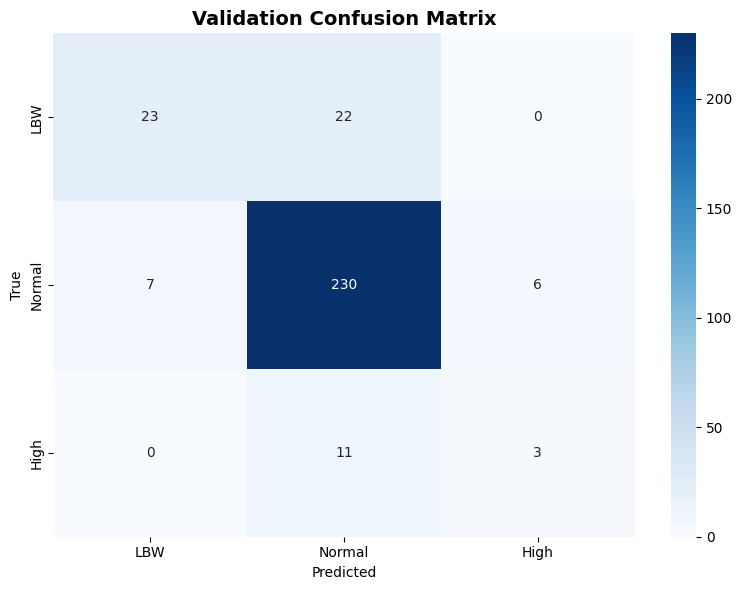


ROC/AUC ANALYSIS


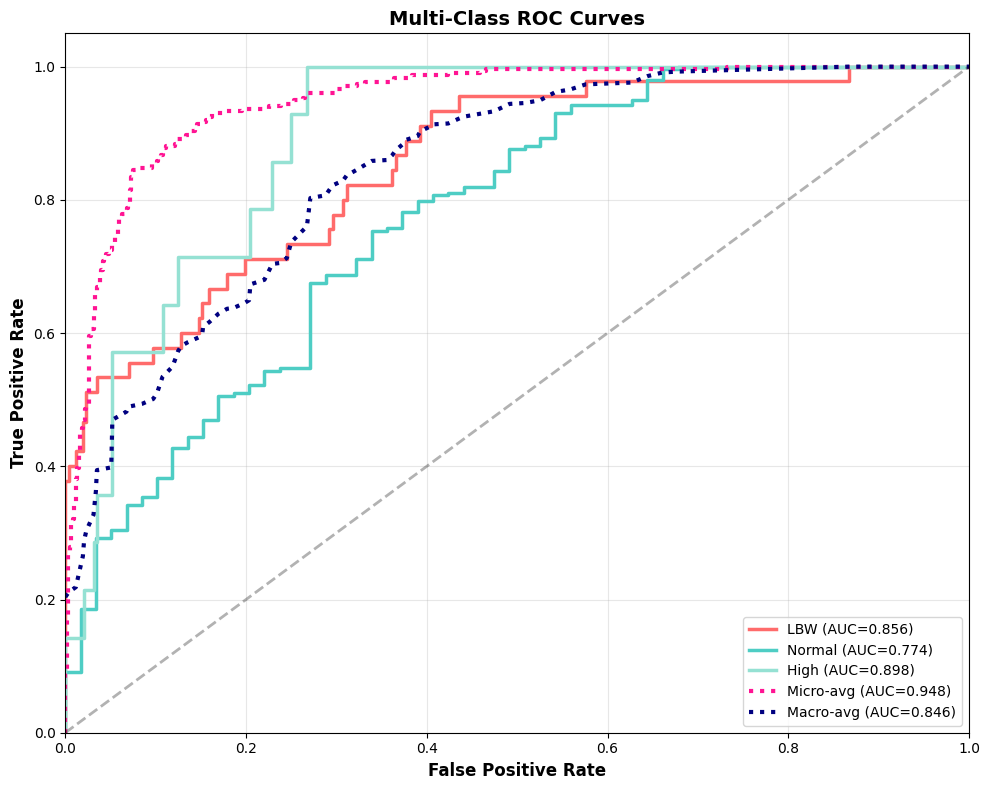


📊 ROC-AUC Summary:
  LBW       : 0.8555
  Normal    : 0.7745
  High      : 0.8981
  Macro-avg : 0.8463

TEST EVALUATION

✅ Test Accuracy: 80.86%
✅ Balanced Accuracy: 47.02%
✅ Macro F1: 49.67%

📊 Classification Report:
              precision    recall  f1-score   support

         LBW     0.6522    0.3333    0.4412        45
      Normal     0.8476    0.9344    0.8889       244
        High     0.1818    0.1429    0.1600        14

    accuracy                         0.8086       303
   macro avg     0.5605    0.4702    0.4967       303
weighted avg     0.7878    0.8086    0.7887       303



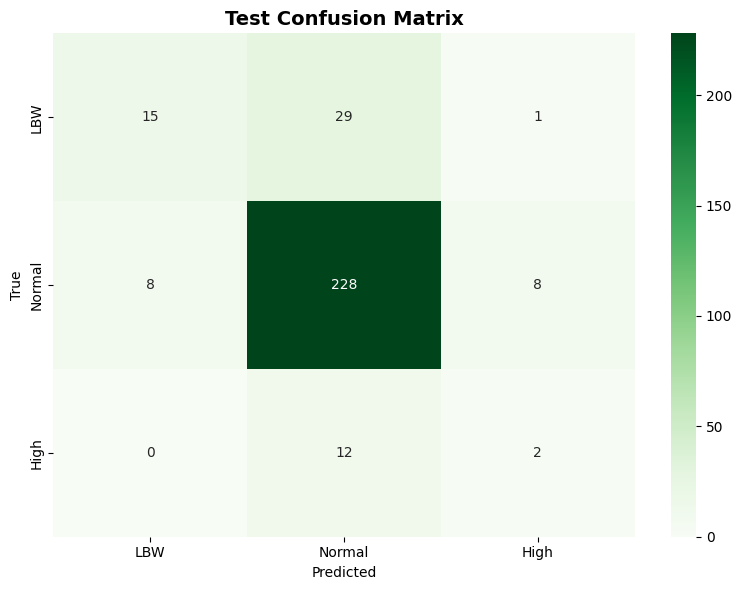


ROC/AUC ANALYSIS


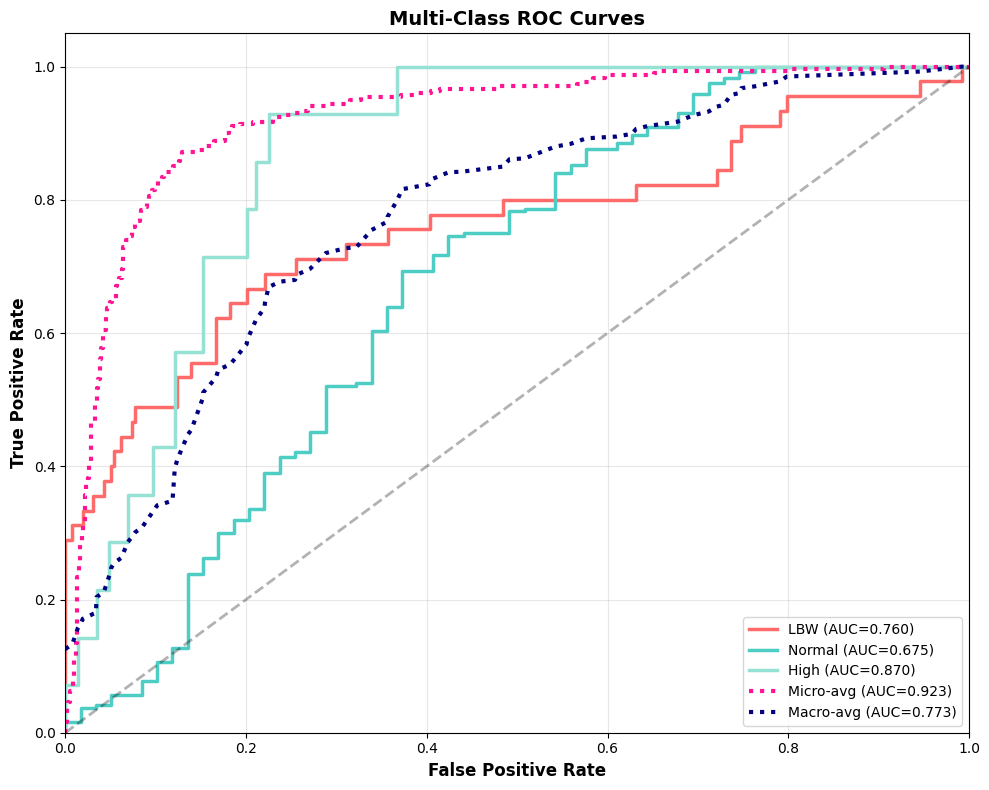


📊 ROC-AUC Summary:
  LBW       : 0.7595
  Normal    : 0.6746
  High      : 0.8705
  Macro-avg : 0.7733

INTERPRETABILITY
🔍 Running SHAP analysis...

🔍 Computing SHAP for LightGBM...
✓ SHAP computed for 100 samples


<Figure size 1000x800 with 0 Axes>

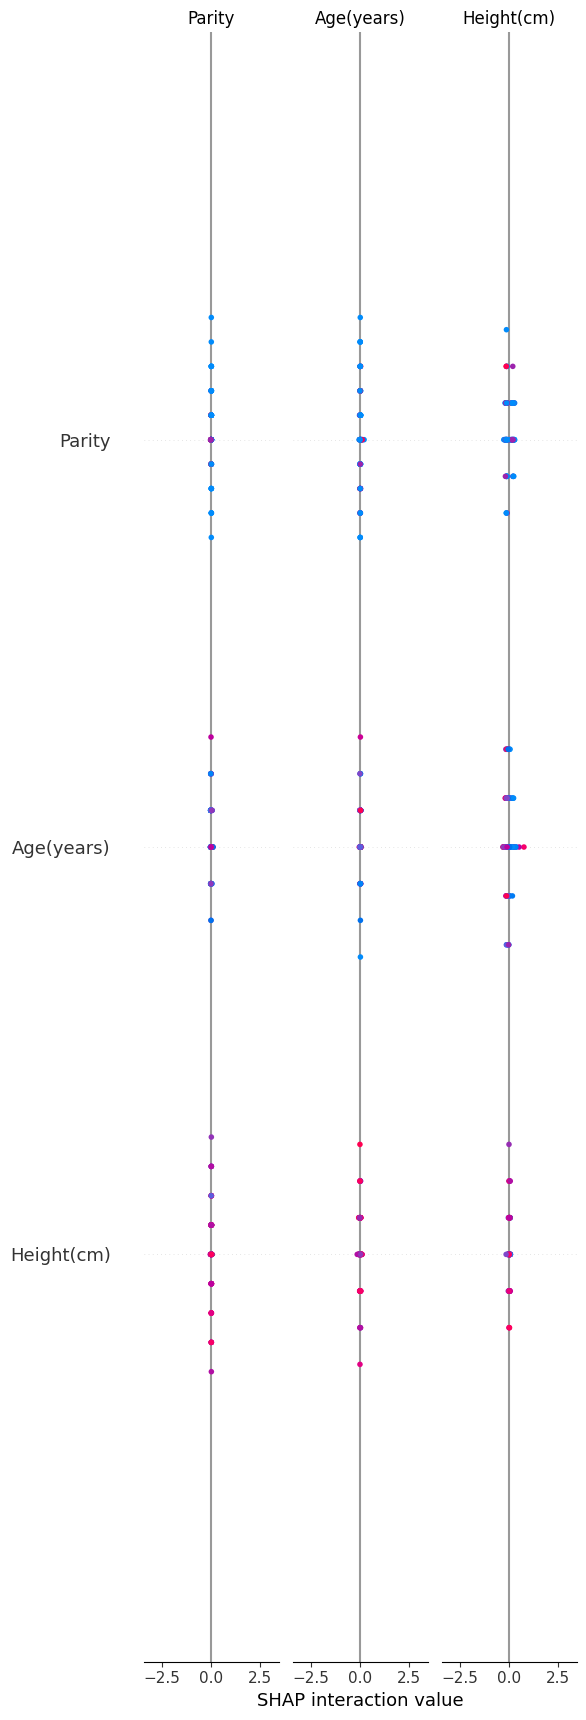

<Figure size 640x480 with 0 Axes>


🔍 Running LIME analysis...

🔍 LIME explanation for sample 0...


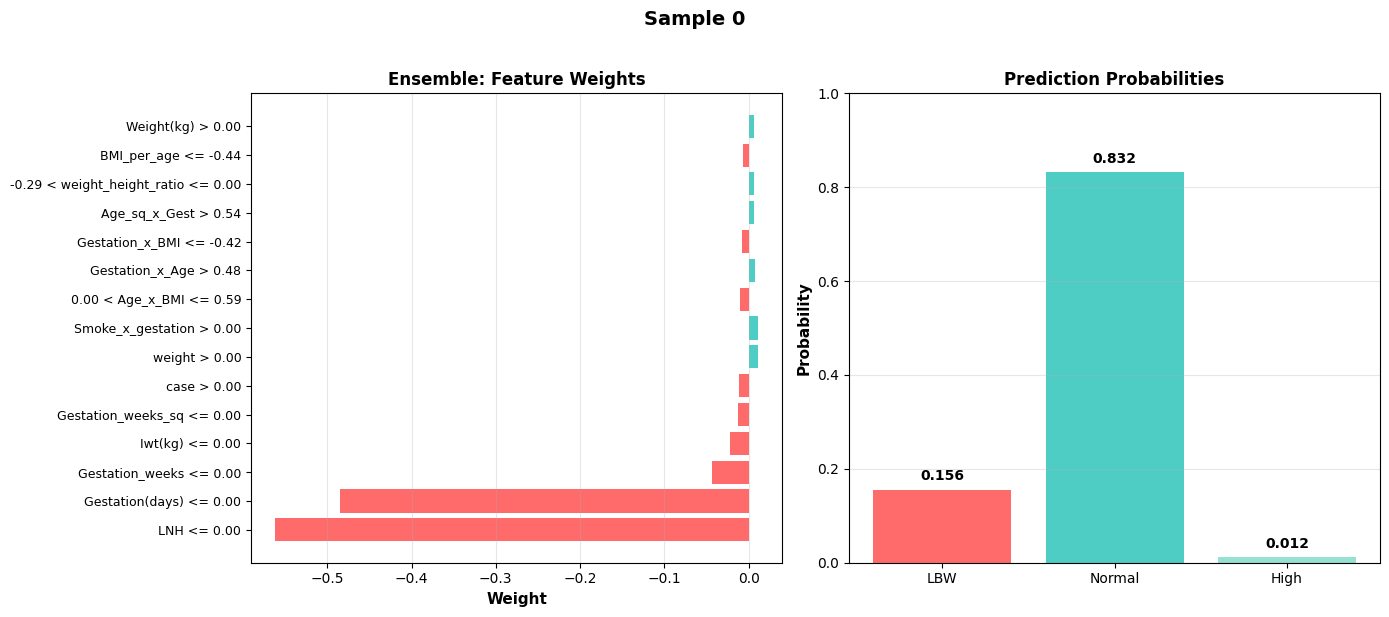


🔍 LIME explanation for sample 5...


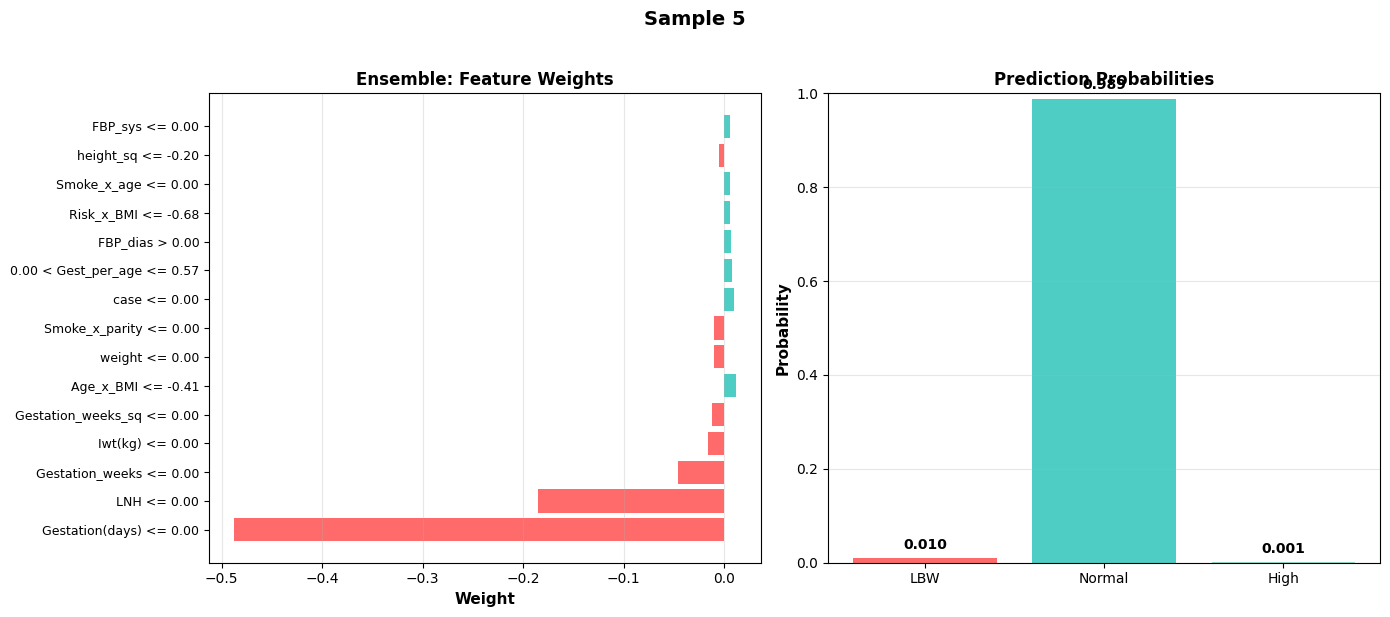


🔍 LIME explanation for sample 10...


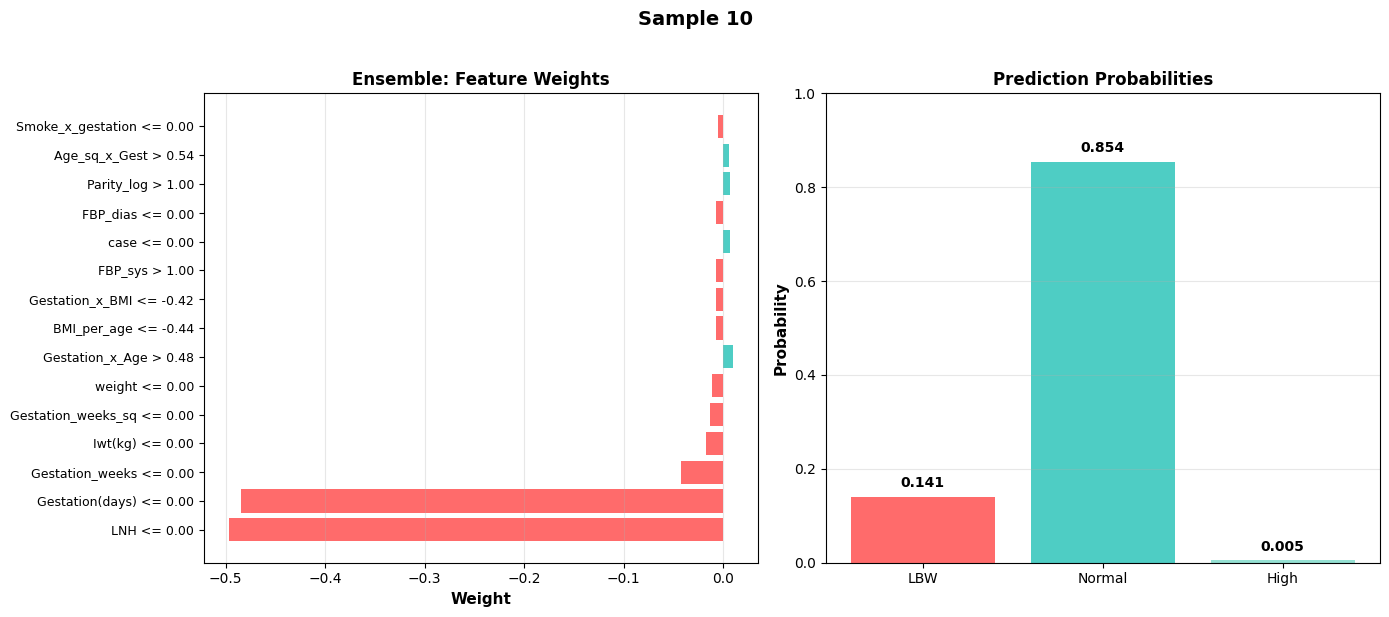


SAVING RESULTS
✅ Predictions saved to test_predictions_BEST.csv
✅ LightGBM model saved to lgb_BEST.txt
✅ Summary saved to summary_BEST.json

📊 BEST RESULTS (Simple Ensemble, No Threshold Tuning):
   Validation: 84.77%
   Test: 80.86%
   Val ROC-AUC: 0.8463
   Test ROC-AUC: 0.7733

🎉 COMPLETE!


In [24]:
# ================================================================================
# SNIPPET 7: EXECUTE PIPELINE (CORRECTED FUNCTION NAME)
# ================================================================================

CBWDB_PATH = '/content/CBWDB.csv'
BABIES_PATH = '/content/babies.csv'

import os
if os.path.exists(CBWDB_PATH) and os.path.exists(BABIES_PATH):
    print("✅ Data files found! Starting high-accuracy pipeline...\n")

    # CORRECTED: Call the new function name
    pipeline_data = run_highaccuracy_pipeline(CBWDB_PATH, BABIES_PATH)

    # Run training and evaluation
    results = train_and_evaluate_BEST(pipeline_data)

    print("\n" + "="*80)
    print("🎉 COMPLETE!")
    print("="*80)

else:
    print("❌ Data files not found!")
    print(f"   Looking for: {CBWDB_PATH}")
    print(f"   Looking for: {BABIES_PATH}")
